In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import torch
import torchvision
import sys
sys.path.insert(0, "../")
import mytorch
from mytorch.tensor import Tensor
from mytorch import nn, optim
import mytorch.functional as F

In [2]:
%load_ext autoreload
%autoreload 2

The aim of this notebook is to recreate the pytorch_mnist notebook using mytorch

### Load data

I'll use torchvision to load the data just for convenience, all training will be done using only mytorch and numpy

In [3]:
train_batch_size = 64
test_batch_size = 64

In [4]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./datasets', train=True, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),
                                  torchvision.transforms.Normalize(0, 1)
                              ])),
    batch_size=train_batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./datasets', train=False, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),
                                  torchvision.transforms.Normalize(0, 1)
                              ])),
    batch_size=test_batch_size, shuffle=True
)

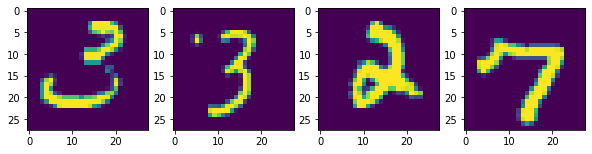

In [5]:
# visualize some images
train_iter = iter(train_loader)
images, labels = train_iter.next()
plt.figure(figsize=(10,8))
for i in range(4):
    ax = plt.subplot(1, 4, i+1)
    ax.imshow(images[i].reshape(28, 28))

### Build simple neural network using mytorch

In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 10)
        
    def forward(self, inputs):
        h1 = self.fc1(inputs)
        a1 = F.relu(h1)
        return self.fc2(a1)

In [7]:
model = Model()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [8]:
losses = []
accuracies = []
for epoch in range(5):
    total_loss = 0
    total_accuracy = 0
    for i, data in tqdm(enumerate(train_loader)):
        images, labels = data
        images = images.numpy() #(64, 1, 28, 28)
        if images.shape[0] != train_batch_size:
            continue
        labels = Tensor(labels.numpy()) #(64,)
        batch_size = images.shape[0]
        
        # forward pass
        optimizer.zero_grad()
        images = Tensor(images.reshape(batch_size, -1))
        outputs = model(images)
        
        # calculate loss
        loss = loss_fn(outputs, labels)
        losses.append(loss.data)
        total_loss += loss.data
        
        # calculate accuracy
        accuracy = (np.argmax(outputs.data, axis=1) == labels.data).sum() / labels.shape[0]
        accuracies.append(accuracy)
        total_accuracy += accuracy
        
        # backward pass, compute gradients
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {total_loss/(i+1)}, Accuracy: {total_accuracy/(i+1)}')

938it [00:15, 60.09it/s]
5it [00:00, 49.39it/s]

Epoch 1, Loss: 5.084745668318042, Accuracy: 0.8588752665245203


938it [00:14, 63.09it/s]
6it [00:00, 55.32it/s]

Epoch 2, Loss: 1.2871611658851054, Accuracy: 0.9130963486140725


938it [00:15, 60.02it/s]
6it [00:00, 54.12it/s]

Epoch 3, Loss: 0.7776024603688235, Accuracy: 0.9278884594882729


938it [00:16, 58.12it/s]
2it [00:00, 14.69it/s]

Epoch 4, Loss: 0.5570725170118818, Accuracy: 0.9350346481876333


938it [00:16, 55.26it/s]

Epoch 5, Loss: 0.4355715876333789, Accuracy: 0.941231343283582


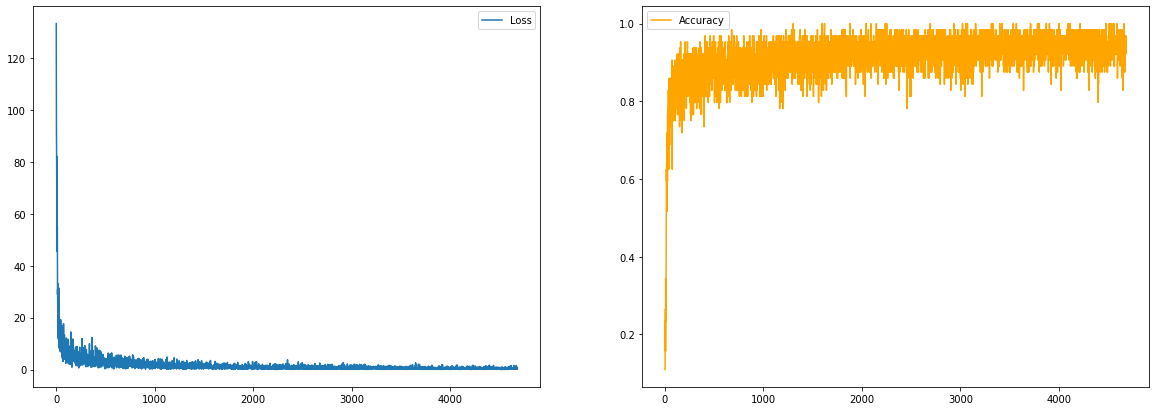

In [9]:
plt.figure(figsize=(20,7))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(losses)
ax1.legend(['Loss'])
ax2 = plt.subplot(1, 2, 2)
ax2.plot(accuracies, color='orange')
ax2.legend(['Accuracy'])
plt.show()

In [10]:
correct = 0
total = 0
for data in test_loader:
    images, labels = data
    images = images.numpy().reshape(images.shape[0], -1)
    if images.shape[0] != 64:
        continue
    images = Tensor(images)
    labels = Tensor(labels.numpy())
    
    # forward pass
    output = model(images)
    
    correct += (np.argmax(output.data, axis=1) == labels.data).sum()
    total += labels.shape[0]
print(f'Accuracy on test set: {correct / total}')

Accuracy on test set: 0.9255809294871795
